# Depth prediction

## Read images from preprocessed file

See [read_kitti.py](read_kitti.py)

In [1]:
dataset_files = ["kitti/dataset.txt"]
dataset_lines = []
for filename in dataset_files:
    with open(filename, "r") as file:
        for line in file:
            dataset_lines.append(line.replace("\n", ""))

print(len(dataset_lines))

3494


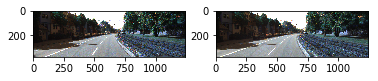

In [3]:
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

fig = plt.figure()
sp = fig.add_subplot(1, 2, 1)
sp.imshow(cv2.imread(dataset_lines[0].split(';')[0]))
sp = fig.add_subplot(1, 2, 2)
sp.imshow(cv2.imread(dataset_lines[0].split(';')[1]))

## Augmentation for a pair images

In [4]:
import tensorflow as tf


def preprocess_test_images(left_image, right_image):
    # randomly flip images
    should_flip = tf.random_uniform([], 0, 1)
    left_image = tf.cond(should_flip > 0.5, lambda: tf.image.flip_left_right(right_image), lambda: left_image)
    right_image = tf.cond(should_flip > 0.5, lambda: tf.image.flip_left_right(left_image), lambda: right_image)

    # randomly augment images
    do_augment = tf.random_uniform([], 0, 1)
    left_image, right_image = tf.cond(do_augment > 0.5, lambda: augment(left_image, right_image), lambda: (left_image, right_image))

    left_image.set_shape([None, None, 3])
    right_image.set_shape([None, None, 3])
    
    return left_image, right_image

    
def augment(left_image, right_image):
    # shift gamma
    random_gamma = tf.random_uniform([], 0.8, 1.2)
    left_image_aug = left_image  ** random_gamma
    right_image_aug = right_image ** random_gamma

    # shift brightness
    random_brightness = tf.random_uniform([], 0.5, 2.0)
    left_image_aug = left_image_aug * random_brightness
    right_image_aug = right_image_aug * random_brightness

    # shift color
    random_colors = tf.random_uniform([3], 0.8, 1.2)
    shape = tf.shape(left_image)
    white = tf.ones([shape[0], shape[1]])
    color_mask = tf.stack([white * random_colors[i] for i in range(3)], axis=2)
    left_image_aug *= color_mask
    right_image_aug *= color_mask

    # normalize
    left_image_aug = tf.clip_by_value(left_image_aug,  0, 1)
    right_image_aug = tf.clip_by_value(right_image_aug, 0, 1)
    
    return left_image_aug, right_image_aug

## Create generator with tf to prevent loading images to the memory

In [5]:
def read_images(lines, input_width=640, input_height=480, batch_size=32):
    input_queue = tf.train.string_input_producer(lines, shuffle=False)
    line_reader = tf.TextLineReader(name="q")
    _, path = line_reader.read(input_queue, name="q")
    
    return tf.string_split([path], ";").values
    # left_image  = tf.image.convert_image_dtype(tf.image.decode_png(tf.read_file(splits[0])), tf.float32, name="q")
    # right_image = tf.image.convert_image_dtype(tf.image.decode_png(tf.read_file(splits[1])), tf.float32, name="q")
    # 
    # left_image  = tf.image.resize_images(left_image,  [input_height, input_width], tf.image.ResizeMethod.AREA)
    # right_image = tf.image.resize_images(right_image, [input_height, input_width], tf.image.ResizeMethod.AREA)
    # 
    # return tf.train.shuffle_batch(
    #     preprocess_test_images(left_image, right_image),
    #     batch_size, 
    #     1024 + 4 * batch_size, 
    #     1024,
    #     4,
    #     allow_smaller_final_batch=True, name='q')

In [6]:
x = tf.convert_to_tensor(dataset_lines, dtype=tf.string)
batch_x, batch_y = read_images(x)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coordinator = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coordinator)
        
    sess.run([batch_x, batch_y])
    
    coordinator.request_stop()
    coordinator.join(threads)
    sess.close()

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.NotFoundError'>, kitti/2011_09_26_drive_0001_sync/image_02/data/0000000000.png;kitti/2011_09_26_drive_0001_sync/image_03/data/0000000000.png
	 [[Node: q_1 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/cpu:0"](q, input_producer)]]

Caused by op 'q_1', defined at:
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-

OutOfRangeError: RandomShuffleQueue '_2_q_4/random_shuffle_queue' is closed and has insufficient elements (requested 32, current size 0)
	 [[Node: q_4 = QueueDequeueUpToV2[component_types=[DT_FLOAT, DT_FLOAT], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](q_4/random_shuffle_queue, q_4/n)]]

Caused by op 'q_4', defined at:
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-0ac9fbc2a4c9>", line 2, in <module>
    batch_x, batch_y = read_images(x)
  File "<ipython-input-5-81cb332f299e>", line 19, in read_images
    allow_smaller_final_batch=True, name='q')
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/input.py", line 1214, in shuffle_batch
    name=name)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/input.py", line 782, in _shuffle_batch
    dequeued = queue.dequeue_up_to(batch_size, name=name)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/data_flow_ops.py", line 499, in dequeue_up_to
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1402, in _queue_dequeue_up_to_v2
    timeout_ms=timeout_ms, name=name)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2334, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/shika/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): RandomShuffleQueue '_2_q_4/random_shuffle_queue' is closed and has insufficient elements (requested 32, current size 0)
	 [[Node: q_4 = QueueDequeueUpToV2[component_types=[DT_FLOAT, DT_FLOAT], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](q_4/random_shuffle_queue, q_4/n)]]


## Setup loss operation and training parameters

In [7]:
rate = 0.001

EPOCHS = 100
BATCH_SIZE = 128

λ = tf.constant(0, dtype=tf.float32)


def get_loss_operation(output):
    size = tf.cast(tf.size(y), tf.float32)
    d = output - tf.log(y)
    return tf.reduce_sum(tf.square(d)) / size - (λ / tf.square(size)) * tf.square(tf.reduce_sum(d))

optimizer = tf.train.AdamOptimizer(learning_rate=rate)

In [8]:
saver = tf.train.Saver()

def evaluate(X_data, y_data, loss_operation, output_shape):
    num_examples = len(X_data)
    total_loss = 0
    sess = tf.get_default_session()
    
    gen = batch_generator(X_data, y_data, batch_size=BATCH_SIZE, output_shape=output_shape)
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = next(gen)
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_loss += loss
    return total_loss

In [1]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(images, depths, test_size=0.2)

NameError: name 'images' is not defined

In [15]:
from sklearn.model_selection import train_test_split
from datetime import datetime
from IPython.display import clear_output, display

def train(output_node, restore=False):
    loss_operation = get_loss_operation(output_node)
    training_operation = optimizer.minimize(loss_operation)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        if restore:
            saver.restore(sess, tf.train.latest_checkpoint('.'))

        num_elements = len(X_train)
        output_shape = output_node.get_shape().as_list()
        gen = batch_generator(X_train, y_train, batch_size=BATCH_SIZE, output_shape=(output_shape[2], output_shape[1]))
        plot_gen = batch_generator(np.array([X_valid[0]]), np.array([y_valid[0]]), batch_size=1, output_shape=(output_shape[2], output_shape[1]))
        plot_img, plot_depth = next(plot_gen)
        
        valid_loss_list = []
        train_loss_list = []
        
        best_loss = float("inf")

        for i in range(0, EPOCHS):
            epoch_begin = datetime.now()
            print("Epoch {}...".format(i + 1))

            training_loss = 0
            for offset in range(0, num_elements, BATCH_SIZE):
                batch_begin = datetime.now()
                batch_x, batch_y = next(gen)
                _, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
                training_loss += loss
                print("{} / {} [{}s]".format(min([offset + BATCH_SIZE, num_elements]), num_elements, (datetime.now() - batch_begin).total_seconds()))
             
            valid_loss = evaluate(X_valid, y_valid, loss_operation, (output_shape[2], output_shape[1]))
            valid_loss_list.append(valid_loss)
            train_loss_list.append(training_loss)
            img = sess.run(output_node, feed_dict = {x: plot_img, y: plot_depth, keep_prob: 1})

            clear_output(wait=True)

            plt.close("all")

            sp = plt.subplot2grid((2, 3), (0, 0), colspan=3)
            sp.plot(
                range(0, len(valid_loss_list)), valid_loss_list, 
                range(0, len(train_loss_list)), train_loss_list, "r--")
            sp = plt.subplot2grid((2, 3), (1, 0))
            sp.imshow(cv2.cvtColor(plot_img[0], cv2.COLOR_YUV2BGR))
            sp = plt.subplot2grid((2, 3), (1, 1))
            sp.imshow(plot_depth[0, :, :, 0], cmap='viridis')
            sp = plt.subplot2grid((2, 3), (1, 2))
            sp.imshow(img[0, :, :, 0], cmap='viridis')
            

            display(plt.gcf())

            print("Epoch {}.".format(i + 1))
            print("Loss: {}.\nCompleted in {}s".format(loss, (datetime.now() - epoch_begin).total_seconds()))

            if best_loss > loss:
                best_loss = loss
                print("Best loss achieved. Saving model to {}".format("model-" + output_node.name.split('/')[0]))
                saver.save(sess, './model-' + output_node.name.split('/')[0])
                
            print()
            print()

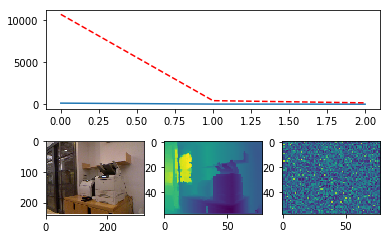

Epoch 3.
Loss: 7.191855430603027.
Completed in 158.543909s
Best loss achieved. Saving model to model-reshaped:0


Epoch 4...
128 / 2501 [6.918528s]
256 / 2501 [6.274924s]
384 / 2501 [6.218964s]
512 / 2501 [6.36267s]
640 / 2501 [6.32809s]
768 / 2501 [6.1367s]
896 / 2501 [6.34166s]
1024 / 2501 [6.383006s]
1152 / 2501 [6.31236s]
1280 / 2501 [6.377544s]
1408 / 2501 [7.158401s]
1536 / 2501 [6.344674s]
1664 / 2501 [6.178384s]
1792 / 2501 [6.223025s]
1920 / 2501 [8.421585s]


KeyboardInterrupt: 

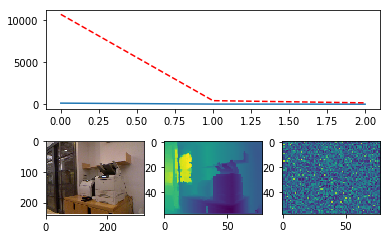

In [16]:
train(reshaped)

In [ ]:
reshaped = tf.stop_gradient(reshaped)
train(fine3, restore=True)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    gen = batch_generator(images, depths, batch_size=1)
    X, Y = next(gen)
    img = sess.run(tf.exp(reshaped), feed_dict={x: X, y: Y, keep_prob: 1.0})
    
    print(img.shape)
    
    fig = plt.figure()
    fig.set_figheight(50)
    fig.set_figwidth(50)
    sp = fig.add_subplot(1, 3, 1)
    sp.imshow(cv2.cvtColor(X[0], cv2.COLOR_YUV2BGR))
    sp = fig.add_subplot(1, 3, 2)
    sp.imshow(Y[0, :, :, 0], cmap='hot')
    sp = fig.add_subplot(1, 3, 3)
    sp.imshow(img[0, :, :, 0], cmap='hot')